# Single qubit/qutrit examples and algorithm usage

In this notebook we use simulated measurements to show how the mGST algorithm is used. <br>
We make sure all the necessary functions are available by running the following python scripts. 

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import numba
import time
from scipy.linalg import expm
from mGST import additional_fns, low_level_jit, algorithm, compatibility


The latest package versions tested are: <br>
numpy==1.21.6 <br>
pygsti==0.9.10 <br>
numba==0.55.1 <br>

You can check your versions via the following command:

In [2]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


numpy==1.21.6
numba==0.55.1


### First, let's create a random unitary gate set and define the parameters that we need:

In [3]:
pdim = 2   # physical dimension
r = pdim**2   # matrix dimension of the gate superoperators
l = 8  # maximum number of gates in each measurement sequence (sequence length)
d = 4  # number of gates in the gate set
rK_true = 1   # rank of simulated gates used for testing
rK = 1   # rank of the mGST model estimate
n_povm = 2   # number of POVM-elements


We can use some of the functions we imported to generate a random gate set.
The function *randKrausSet_Haar(d,r,rK_true)* generates d sets of Kraus operators, where each set is found by taking a Haar random unitary and using a subset of its columns the generate an isometry of shape (rK_true*pdim) x (pdim). <br>
For an initial state and a POVM element we can simply take a computational basis elements.

In [4]:
K_true = additional_fns.randKrausSet_Haar(
    d, r, rK_true)   # tensor of random Kraus operators
X_true = np.einsum('ijkl,ijnm -> iknlm', K_true, K_true.conj()
                   ).reshape(d, r, r)   # tensor of superoperators

K_depol = additional_fns.depol(pdim, 0.02)  # Kraus-rep of depolarizing channel
G_depol = np.einsum('jkl,jnm -> knlm', K_depol, K_depol.conj()).reshape(r, r)
# |10> initial state with depolarizing noise
rho_true = G_depol@np.array([[1, 0], [0, 0]]).reshape(-1).astype(np.complex128)

# Computational basis measurement:
E1 = np.array([[1, 0], [0, 0]]).reshape(-1)
E2 = np.array([[0, 0], [0, 1]]).reshape(-1)
E_true = np.array([E1, E2]).astype(np.complex128)   # Full POVM


Next up we need some gate sequence instructions and simulated measurements. Each gate is identified by an index between 0 and d-1, meaning a gate sequences can most simply be represented by a list of gate indices. We write a full set containing *N* many sequence instructions as a numpy array *J* of shape *N* x *d*. The resulting state after each sequences is measured *meas_samples*-times with a POVM consisting of *n_povm* many alements. Therefore we will have *n_povm*-many estimated probabilites per sequences and we can collect all results in a numpy array *y* of shape *n_povm* x *N*. 

In [5]:
N = 100  # Number of sequences
meas_samples = 1e5  # Number of samples per sequences
# generate random numbers between 0 and $d^l - 1$
J_rand = np.array(random.sample(range(d**l), N))
# turn random numbers into gate instructions
J = np.array([low_level_jit.local_basis(ind, d, l) for ind in J_rand])
y = np.real(np.array([[E_true[i].conj()@low_level_jit.contract(X_true, j)@rho_true for j in J]
            for i in range(n_povm)]))   # obtain ideal output probabilities
# simulate finite sampling statistics
y_sampled = additional_fns.sampled_measurements(y, meas_samples).copy()


For our first test we use an initialitation where the state preparation and measurement are random, but the gate are just rotated versions of the ideal gates. 

In [6]:
delta = .1  # unitary noise parameter

# Generate noisy version of true gate set
K0 = np.zeros((d, rK, pdim, pdim)).astype(np.complex128)
for i in range(d):
    U_p = expm(delta*1j*additional_fns.randHerm(pdim)
               ).astype(np.complex128)   # unitary noise
    K0[i] = np.einsum('jkl,lm', K_true[i], U_p)
X0 = np.einsum('ijkl,ijnm -> iknlm', K0, K0.conj()).reshape(d, r, r)

rho0 = additional_fns.randpsd(r).copy()   # random initial state
A0 = additional_fns.randKrausSet(1, r, n_povm)[0].conj()   # random POVM decomposition
E0 = np.array([(A0[i].T.conj()@A0[i]).reshape(-1)
              for i in range(n_povm)]).copy()

Now it's time to run mGST on the data set. Note that if the algorithm is run for the first time on a new machine it can take up to a few minutes to compile the low level functions (such as derivatives). <br>
The main function is called *run_mGST*, for information it's variables and outputs we can call the help(run_mGST):

Starting optimization...
 77%|████████████████████████████████▉          | 23/30 [00:28<00:08,  1.26s/it]
Optimization successful, improving estimate over full data....
 50%|██████████████████████                      | 5/10 [00:20<00:20,  4.10s/it]
#################
	 Convergence criterion satisfied
	 Final objective function value 1.2701900011841689e-06 with # of initializations: 1 
 	 Total runtime: 49.87487506866455


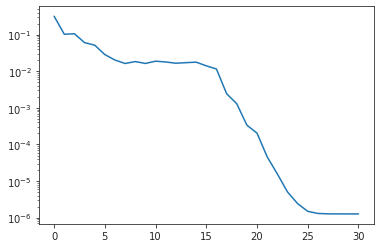

Mean variation error: 0.00047059049578387804


In [7]:
bsize = 50   # The batch size on which the optimization is started
K, X, E, rho, res_list = algorithm.run_mGST(y_sampled, J, l, d, r, rK, n_povm, bsize, meas_samples, method='SFN',
                                  max_inits=10, max_iter=30, final_iter=10,
                                  target_rel_prec=1e-4, init=[K0, E0, rho0])
plt.semilogy(res_list)   # plot the objective function over the iterations
plt.show()
print('Mean variation error:', additional_fns.MVE(X_true, E_true, rho_true, X, E,
      rho, d, l, n_povm)[0])   # output the final mean variation error


### A note on hyperparameters
**bsize:** This controls the "batch size", meaning how many of the total sequences are sampled per initialization step. This is done until a good estimate is reached, which is afterwards improved on the dull set of sequences. 
A too small value of bsize leads to chaotic jumping in the parameter space without convergence, while a too large value leads to longer runtimes. Generally, the more free parameters a model has, the higher the batch size needs to be. Good heuristic values are: <br>
bsize = 50 for a single quabit gate set of 3 gates, <br>
bsize = 80 for a single qutrit gate set of 6 gates. <br>
bsize = 120 for a two qubit gate set of 6 gates.

**max_inits:** Controls the maximum number of reinitializations, this can be increased if the algorithm doesn't converge. The target Kraus rank rK can have a large influence on the required number of initializations and we find that in many cases rK=2 requires fewer initializations than rK=1 (See also discussion in https://arxiv.org/abs/2112.05176).

**max_iter:** Maximum number of iterations spend on the batch optimization per initialization. Generally values around 150-200 are a good trade off between leaving enough iterations to converge if an optimal value can be reached from the given initialization, and not spending too much time on a bad initialization.

**final_iter** and **target_rel_prec:** If the convergence criterion is satisfied, a maximum of final_iter - many iterations on the full dataset are performed to fully converge. If the iteration on iteration improvement on the objective function is less than target_rel_prec * delta, where delta is the convergence threshold, then the final iteration loop is terminated and a the resulting gate set estimate is returned. If computation time is not an issue and higher precision of the estimator is desired, then target_rel_prec can be decreased and final_iter increased.

## XYI gate set $\{\mathrm{Id}, e^{i \frac{\alpha}{2} \sigma_y}, e^{i \frac{\alpha}{2} \sigma_x}\}$ from random initialization
The XYI gate set is a minimal gate set that is tomographically complete when applied to the $|0><0|$ state and constitutes a standard example for gate set tomography. In this example we don't give an initialization to mGST, resulting in a random initialization to be generated automatically. As a result, more than one initialization attempt might be necessary to converge to a satisfying objective funtion value. We can tweak the number of allowerd initializations with the *max_inits* parameter.

In [40]:
from pygsti.modelpacks import smq1Q_XYI as std
mdl_datagen = std.target_model().depolarize(0.01).randomize_with_unitary(
    0.01)   # use pygsti-function to add noise
X_true, E_true, rho_true = compatibility.pygsti_model_to_arrays(
    mdl_datagen, basis='std')   # turn pygsti model object into numpy arrays

pdim = 2
r = pdim**2

l = 7
d = 3

n_povm = 2
rK = 2

In [41]:
sequence_count = 100
meas_samples = 1e3
J_rand = np.array(random.sample(range(d**l), sequence_count))
J = np.array([low_level_jit.local_basis(ind, d, l) for ind in J_rand])
y = np.real(np.array([[E_true[i].conj()@low_level_jit.contract(X_true, j)
            @ rho_true for j in J] for i in range(n_povm)]))
y_sampled = additional_fns.sampled_measurements(y, meas_samples).copy()

For the following run we set the parameter "testing = True", which plots the objective function over the number of iterations for every initialization attempt. <br>
This helps in finding problems, for instance if max_iter was set too low to allow convergence, the plot will show continued decrease of the objective function up until the iteration limit, without reaching the success threshold. Another problem that can come up is model mismatch, for instance if rK is set to 1, but the actual gate set can not be well approximated by a Rank 1 Channel. Then the default success criterion might be too stringent, since no gate set in the Rank 1 model class can attain a low enough error. This can be fixed by setting the optional variable "threshold_multiplyer" to a higher value (the default ist threshold_multiplyer = 3).

Starting optimization...
100%|██████████| 100/100 [00:35<00:00,  2.85it/s]


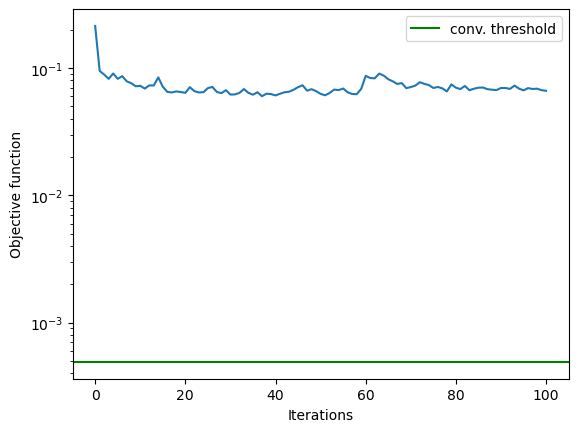

Run  0 failed, trying new initialization...
 34%|███▍      | 34/100 [00:16<00:31,  2.09it/s]


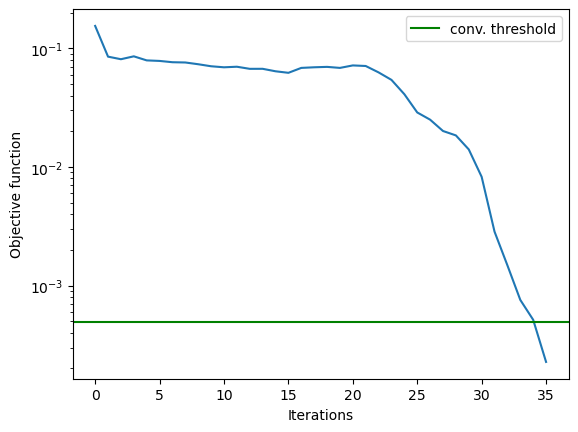

Initialization successful, improving estimate over full data....
100%|██████████| 10/10 [00:07<00:00,  1.27it/s]
#################
	 Convergence criterion satisfied
	 Final objective function value 8.972249805303893e-05 with # of initializations: 2 
 	 Total runtime: 60.14927124977112
Mean variation error: (0.008006655080104907, 0.05238357452923559)


In [26]:
bsize = 50
t0 = time.time()
K, X, E, rho, res_list = algorithm.run_mGST(y_sampled, J, l, d, r, rK, n_povm, bsize, meas_samples, method='SFN',
                                  max_inits=5, max_iter=100, final_iter=10,
                                  target_rel_prec=1e-4, testing=True)
print('Mean variation error:', additional_fns.MVE(
    X_true, E_true, rho_true, X, E, rho, d, l, n_povm))


## GST on a 3-level system
This example considers a qutrit gate set made up of a qutrit Hadamard gate, as well as X- and Z-gate defined on two-level subspaces. The gate set was previously used for gate set tomography in https://arxiv.org/pdf/2210.04857.pdf

In [27]:
pdim = 3
r = pdim**2
l = 8
d = 6
rK = 2
n_povm = 3

In [28]:
w = np.exp(1j*2*np.pi/3)
K_true = np.zeros((6, 1, 3, 3)).astype(np.complex128)
K_true[0] = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])  # Identity
K_true[1] = np.array([[1, 1, 1], [1, w, w**2], [1, w**2, w]]
                     )/np.sqrt(3)  # Hadamard
# Single qubit X-gate on the {|100>, |010>} subspace
K_true[2] = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]])
# Single qubit X-gate on the {|010>, |001>} subspace
K_true[3] = np.array([[1, 0, 0], [0, 0, 1], [0, 1, 0]])
K_true[4] = np.array([[1, 0, 0], [0, w, 0], [0, 0, 1]]
                     )  # Phase gate on the |010> state
K_true[5] = np.array([[1, 0, 0], [0, 1, 0], [0, 0, w]]
                     )  # Phase gate on the |001> state


We can also be more creative with the noise model and generate random noise channels that have vartiable distance to the identity channels:

In [29]:
# Gate set tensor consisting of all gate superoperators
X_ideal = np.einsum('ijkl,ijnm -> iknlm', K_true,
                    K_true.conj()).reshape(d, r, r)
# Generates Kraus representations of random channels; The parameter a controls the distance from the identity channel
K_Lambda = additional_fns.randKrausSet(d, r, 9, a=0.2)
X_id = np.array([np.eye(r) for _ in range(d)])  # Identity channels

Lambda = np.einsum('ijkl,ijnm -> iknlm', K_Lambda, K_Lambda.conj()
                   ).reshape(d, r, r)  # Gate set tensor of noise channels
# Noise channels applied to the ideal gates
X_true = np.einsum('ijk,ikl -> ijl', X_ideal, Lambda)

K_depol = additional_fns.depol(pdim, 0.02)  # Kraus-rep of depolarizing channel
G_depol = np.einsum('jkl,jnm -> knlm', K_depol, K_depol.conj()).reshape(r, r)
# |100> initial state with depolarizing noise
rho_true = G_depol@np.array([[1, 0, 0], [0, 0, 0],
                            [0, 0, 0]]).reshape(-1).astype(np.complex128)

# Computational basis measurement:
E1 = np.array([[1, 0, 0], [0, 0, 0], [0, 0, 0]]).reshape(-1)
E2 = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]).reshape(-1)
E3 = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]]).reshape(-1)
E_true = np.array([E1, E2, E3]).astype(np.complex128)   # Full POVM


In [30]:
# A handy function to test whether a gate set satisfies all positivity and normalization constraints:
additional_fns.is_positive(X_true, E_true, rho_true)

Gate 0 positive: True
Gate 0 trace preserving: True
Gate 1 positive: True
Gate 1 trace preserving: True
Gate 2 positive: True
Gate 2 trace preserving: True
Gate 3 positive: True
Gate 3 trace preserving: True
Gate 4 positive: True
Gate 4 trace preserving: True
Gate 5 positive: True
Gate 5 trace preserving: True
Initial state positive: True
Initial state normalization: (1.0000000000000002+0j)
POVM valid: True


In [31]:
N = 300  # Number of sequences
meas_samples = 1e3  # Number of samples per sequences
# generate random numbers between 0 and $d^l - 1$
J_rand = np.array(random.sample(range(d**l), N))
# turn random numbers into gate instructions
J = np.array([low_level_jit.local_basis(ind, d, l) for ind in J_rand])
y = np.real(np.array([[E_true[i].conj()@low_level_jit.contract(X_true, j)@rho_true for j in J]
            for i in range(n_povm)]))   # obtain ideal output probabilities
# simulate finite sampling statistics
y_sampled = additional_fns.sampled_measurements(y, meas_samples).copy()


Starting optimization...
 60%|██████    | 181/300 [05:01<03:18,  1.66s/it]
Initialization successful, improving estimate over full data....
100%|██████████| 30/30 [02:22<00:00,  4.75s/it]
#################
	 Convergence criterion satisfied
	 Final objective function value 0.00010446849006816751 with # of initializations: 1 
 	 Total runtime: 443.78416204452515


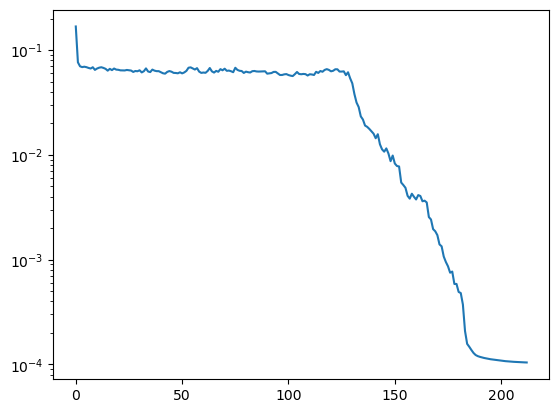

Mean variation error: 0.009068105785290272


In [32]:
bsize = 80   # The batch size on which the optimization is started
K, X, E, rho, res_list = algorithm.run_mGST(y_sampled, J, l, d, r, rK, n_povm, bsize, meas_samples, method='SFN',
                                  max_inits=10, max_iter=300, final_iter=30,
                                  target_rel_prec=1e-4)
plt.semilogy(res_list)   # plot the objective function over the iterations
plt.show()
print('Mean variation error:', additional_fns.MVE(X_true, E_true, rho_true, X, E,
      rho, d, l, n_povm)[0])   # output the final mean variation error
